This notebook is aiming at kicking off comprehend inference job using boto3 comprehend api.

Prerequisite:

1) Valid AWS accounts with permission to access comprehend

2) A trained comprehend custom classifier

3) Prepared test data saved in S3 in a format of "ONE_DOC_PER_LINE". In the example, test file name is "test_data.csv"

Output:

1) Output of inference job is saved in S3 location

In [ ]:
# Import required libraires
import pandas as pd
import boto3

In [ ]:
# Specify comprehend region and client
REGION = 'us-east-1'
comprehend = boto3.client('comprehend', region_name = REGION)

##### Prepare Test Data

According to Comprehend Developer Guide, with the One document per line format, each document is placed on a separate line and no header is used. The label is not included on each line (since you don't yet know the label for the document). 

In this example, we will use Textract DataFrame "Textract_output_train05" (Output for NON-OCR-1) as an exmple.

In [ ]:
textract_df = pd.read_csv("Textract_output_train05.csv")
test_data = textract_df['content'].to_csv("test_data.csv", index=False, header=False)

The test_data.csv generated here will be used as the input file for Comprehend inference job. In the meanwhile, Textract_output_train05.csv file contains all the metainfo (filename, page_number..) that are necessary to execute STEP-6 notebook. 

##### Boto3 Comprehend API

In [ ]:
# Specify parameters
s3url = 's3://scio-saas-datastores/SaaS_workspace/aws_comprehend/inputs/test_data.csv'
input_format = 'ONE_DOC_PER_LINE'
output_s3url = 's3://scio-saas-datastores/SaaS_workspace/aws_comprehend/output/batch3_content_test'
key_id = "arn:aws:kms:us-east-1:097079433570:key/1c6d057c-0be3-40a6-b23c-5870a92b901f"
data_access_role_arn = "arn:aws:iam::097079433570:role/service-role/AmazonComprehendServiceRole-aws_scio_S3Datastore_servicewrite"

In [ ]:
# Specify trained comprehend model arn
model_arn = 'arn:aws:comprehend:us-east-1:097079433570:document-classifier/exl-custom-classifier-yy-multi-label-batch123'

In [ ]:
response = comprehend.start_document_classification_job(
            InputDataConfig = {
                'S3Uri' : s3url,
                'InputFormat' : input_format
            },
            OutputDataConfig = {
                'S3Uri' : output_s3url,
                'KmsKeyId' : key_id
            },
            DataAccessRoleArn = data_access_role_arn,
            VolumeKmsKeyId = key_id,
            DocumentClassifierArn = model_arn)

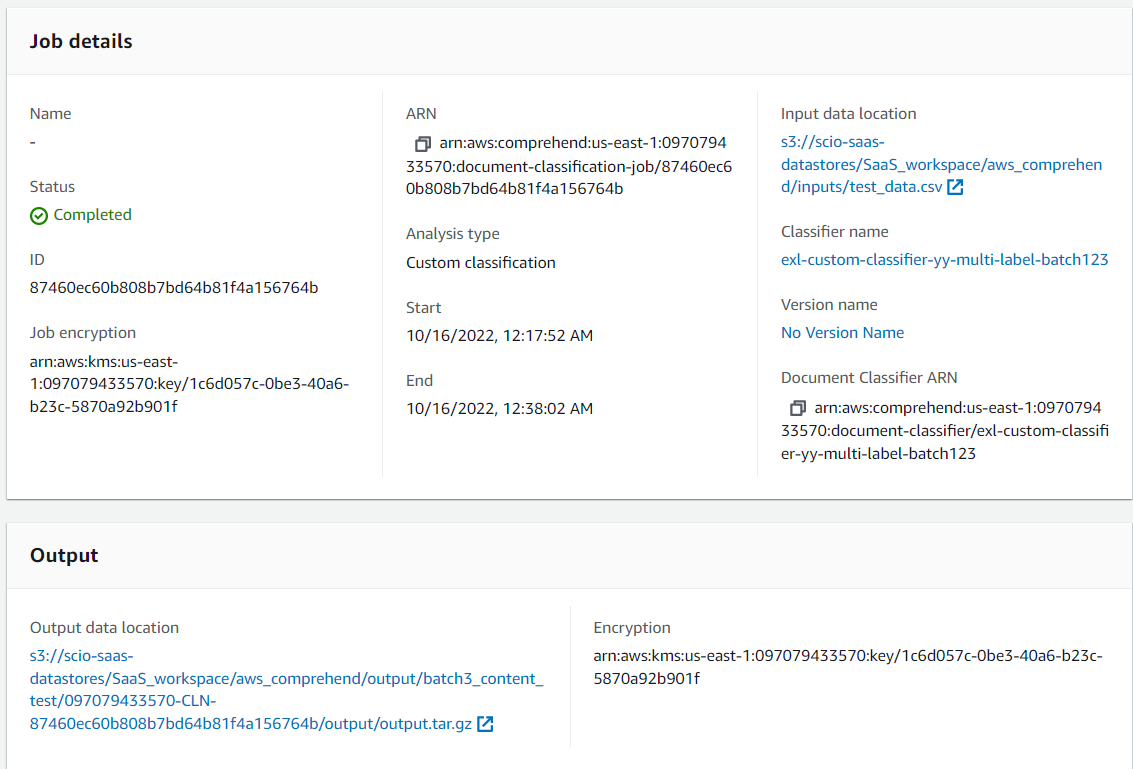

##### Inference Pipeline

Go to AWS Console, open Lambda service and click CompStartInferenceLambda.

Go to configuration field and click Environment Variables, Click Edit and Edit the DOC_CLASS_ARN with the model ARN needs to be test with.

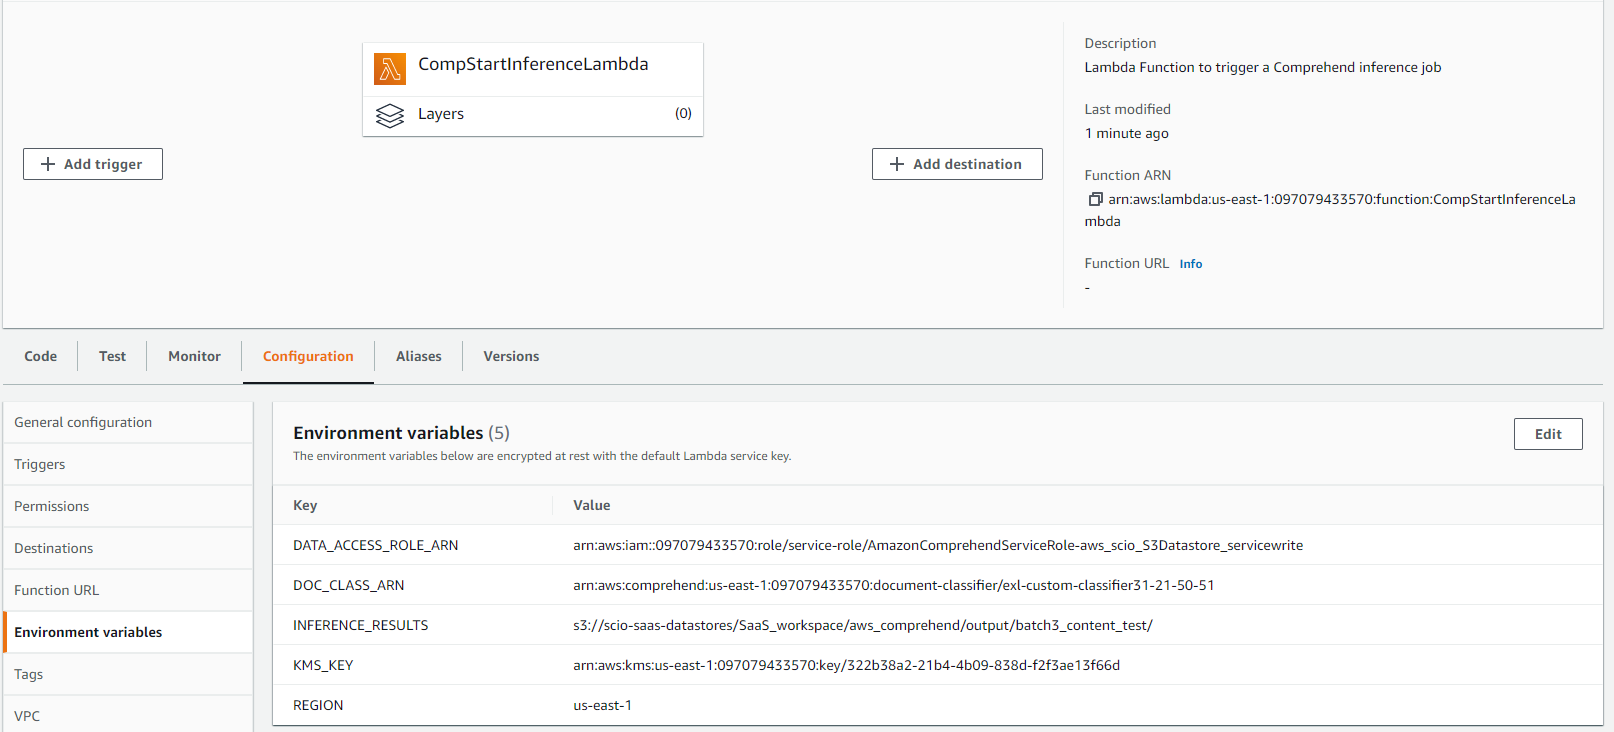

This inference pipeline monitors S3 location scio-test01/SaaS_workspace/aws_comprehend/inputs/. Once uploading test file to the location, inference pipeline will trigger inference job automatically

In [ ]:
s3 = boto3.resource('s3')
# upload inference file to S3
s3.Bucket('scio-test01').upload_file('test_data.csv', 'SaaS_workspace/aws_comprehend/inputs/test_data.csv')

The status of inference job can be monitored by stepfunction ComprehendInferenceSM

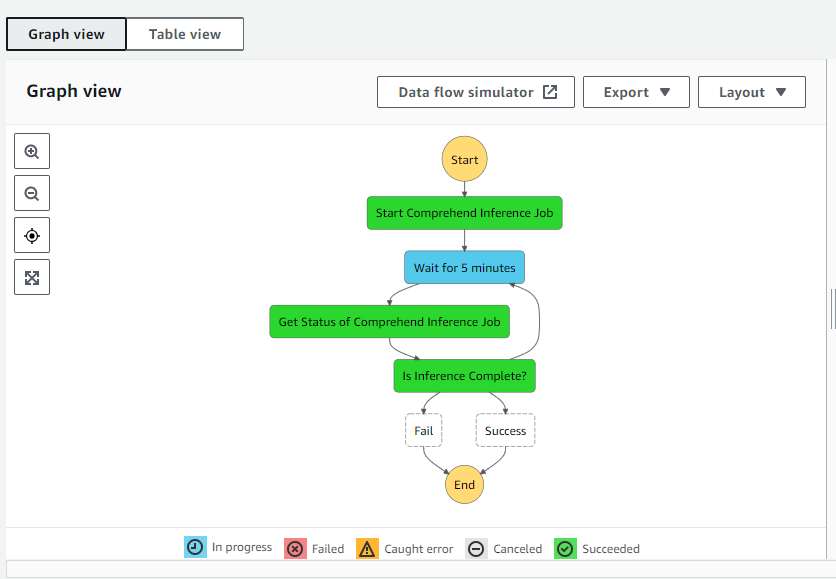